In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd
import numpy as np
from gtda.time_series import SlidingWindow
import matplotlib.pyplot as plt
from math import atan2, pi, sqrt, cos, sin, floor
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True  
config.log_device_placement = True  
sess2 = tf.compat.v1.Session(config=config)
set_session(sess2)  
from tensorflow.keras.layers import Dense, MaxPooling1D, Flatten
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.compat.v1.keras.backend as K
from tensorflow.keras.models import load_model
from tcn import TCN, tcn_full_summary
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform
from keras_flops import get_flops
import pickle
import csv
import random
import itertools
import math
import time
from dataset0.data_utils_0_revised import *
from traj_utils import *

Device mapping: no known devices.


## Import Dataset

In [3]:
window_size = 100
stride = 20

f = 'dataset0/'
X_train,Y_Pos_train, Physics_Vec_train, x_vel_train, y_vel_train, x0_list_train, y0_list_train, size_of_each_train = import_agrobot_dataset_p1(dataset_folder=f, type_flag=1, window_size=window_size, stride=stride)
P = np.repeat(Physics_Vec_train,window_size).reshape((Physics_Vec_train.shape[0],window_size,1))
X_train = np.concatenate((X_train,P),axis=2)

X_test,Y_Pos_test, Physics_Vec_test, x_vel_test, y_vel_test, x0_list_test, y0_list_test, size_of_each_test= import_agrobot_dataset_p1(type_flag = 2, dataset_folder=f,window_size=window_size, stride=stride)
P_test = np.repeat(Physics_Vec_test,window_size).reshape((Physics_Vec_test.shape[0],window_size,1))
X_test = np.concatenate((X_test,P_test),axis=2)

List of log files being imported:  ['Log1, 100.csv', 'Log2, 100.csv', 'Log3, 100.csv', 'Log4, 100.csv', 'Log6, 100.csv', 'Log7, 100.csv', 'Log9, 100.csv']


100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


List of log files being imported:  ['Log5, 100.csv', 'Log8, 100.csv']


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


## Model Training

In [4]:
nb_filters = 32
kernel_size = 5
dilations = [1,2,4,8,16,32,64,128]
dropout_rate = 0.0
use_skip_connections = True

batch_size, timesteps, input_dim = 256, window_size, X_train.shape[2]
i = Input(shape=(timesteps, input_dim))

m = TCN(nb_filters=nb_filters,kernel_size=kernel_size,dilations=dilations,dropout_rate=dropout_rate,
            use_skip_connections=use_skip_connections)(i)  

m = tf.reshape(m, [-1, nb_filters, 1])
m = MaxPooling1D(pool_size=(2))(m)
m = Flatten()(m)
m = Dense(32, activation='linear', name='pre')(m)
output1 = Dense(1, activation='linear', name='velx')(m)
output2 = Dense(1, activation='linear', name='vely')(m)
model = Model(inputs=[i], outputs=[output1, output2])
opt = tf.keras.optimizers.Adam()
model.compile(loss={'velx': 'mse','vely':'mse'},optimizer=opt)  
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 7)]     0                                            
__________________________________________________________________________________________________
tcn (TCN)                       (None, 32)           78688       input_1[0][0]                    
__________________________________________________________________________________________________
tf.reshape (TFOpLambda)         (None, 32, 1)        0           tcn[0][0]                        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 16, 1)        0           tf.reshape[0][0]                 
______________________________________________________________________________________________

In [5]:
model_name = 'Agrobot_First_TCN.hdf5'
checkpoint = ModelCheckpoint(model_name, monitor='loss', verbose=1, save_best_only=True)
model.fit(x=X_train, y=[x_vel_train, y_vel_train],epochs=3000, shuffle=True,callbacks=[checkpoint],batch_size=batch_size)     

Epoch 1/3000
352/352 [==============================] - 68s 189ms/step - loss: 0.5757 - velx_loss: 0.3474 - vely_loss: 0.2282

Epoch 00001: loss improved from inf to 0.57566, saving model to Agrobot_First_TCN.hdf5
Epoch 2/3000
352/352 [==============================] - 66s 187ms/step - loss: 0.0591 - velx_loss: 0.0341 - vely_loss: 0.0250

Epoch 00002: loss improved from 0.57566 to 0.05912, saving model to Agrobot_First_TCN.hdf5
Epoch 3/3000
352/352 [==============================] - 66s 188ms/step - loss: 0.0350 - velx_loss: 0.0198 - vely_loss: 0.0152

Epoch 00003: loss improved from 0.05912 to 0.03499, saving model to Agrobot_First_TCN.hdf5
Epoch 4/3000
352/352 [==============================] - 66s 188ms/step - loss: 0.0268 - velx_loss: 0.0148 - vely_loss: 0.0119

Epoch 00004: loss improved from 0.03499 to 0.02677, saving model to Agrobot_First_TCN.hdf5
Epoch 5/3000
352/352 [==============================] - 65s 186ms/step - loss: 0.0232 - velx_loss: 0.0127 - vely_loss: 0.0106

Epoch

KeyboardInterrupt: 

: 

## Evaluation

In [6]:
model_name = 'Agrobot_First_TCN.hdf5'
model = load_model(model_name,custom_objects={'TCN':TCN})

Unseen Trajectories

In [7]:
ATE = []
RTE = []
ATE_dist = []
RTE_dist = []
for i in range(len(size_of_each_test)):
    Pvx, Pvy = model_pos_generator(X_test, size_of_each_test, 
                   x0_list_test, y0_list_test, window_size, stride,i,model)   
    Gvx, Gvy = GT_pos_generator(x_vel_test,y_vel_test,size_of_each_test,
                                x0_list_test, y0_list_test, window_size, stride,i)
    
    at, rt, at_all, rt_all = Cal_TE(Gvx, Gvy, Pvx, Pvy,
                                    sampling_rate=100,window_size=window_size,stride=stride)
    ATE.append(at)
    RTE.append(rt)
    ATE_dist.append(Cal_len_meters(Gvx, Gvy))
    RTE_dist.append(Cal_len_meters(Gvx, Gvy, 600))
    print('ATE, RTE, Trajectory Length, Trajectory Length (60 seconds)',ATE[i],RTE[i],ATE_dist[i],RTE_dist[i])
    
print('Median ATE and RTE', np.median(ATE),np.median(RTE))
print('Mean ATE and RTE', np.mean(ATE),np.mean(RTE))
print('STD ATE and RTE', np.std(ATE),np.std(RTE))

ATE, RTE, Trajectory Length, Trajectory Length (60 seconds) 11.597819785546104 1.8475261978411983 287.85761662195137 28.016093619359395
ATE, RTE, Trajectory Length, Trajectory Length (60 seconds) 50.515676785565894 1.9532176482685595 233.75425011648193 21.70077385129724
Median ATE and RTE 31.056748285555997 1.900371923054879
Mean ATE and RTE 31.056748285555997 1.900371923054879
STD ATE and RTE 19.458928500009897 0.05284572521368058


Seen Trajectories

In [8]:
ATE = []
RTE = []
ATE_dist = []
RTE_dist = []
for i in range(len(size_of_each_train)):
    Pvx, Pvy = model_pos_generator(X_train, size_of_each_train, 
                   x0_list_train, y0_list_train, window_size, stride,i,model)   
    Gvx, Gvy = GT_pos_generator(x_vel_train,y_vel_train,size_of_each_train,
                                x0_list_train, y0_list_train, window_size, stride,i)
    
    at, rt, at_all, rt_all = Cal_TE(Gvx, Gvy, Pvx, Pvy,
                                    sampling_rate=100,window_size=window_size,stride=stride)
    ATE.append(at)
    RTE.append(rt)
    ATE_dist.append(Cal_len_meters(Gvx, Gvy))
    RTE_dist.append(Cal_len_meters(Gvx, Gvy, 600))
    print('ATE, RTE, Trajectory Length, Trajectory Length (60 seconds)',ATE[i],RTE[i],ATE_dist[i],RTE_dist[i])
    
print('Median ATE and RTE', np.median(ATE),np.median(RTE))
print('Mean ATE and RTE', np.mean(ATE),np.mean(RTE))
print('STD ATE and RTE', np.std(ATE),np.std(RTE))

ATE, RTE, Trajectory Length, Trajectory Length (60 seconds) 9.929583229033165 0.41834522715670747 275.9200046693735 26.05521985043159
ATE, RTE, Trajectory Length, Trajectory Length (60 seconds) 10.57364107621656 0.45888140362517477 288.5516252739624 26.686326997524706
ATE, RTE, Trajectory Length, Trajectory Length (60 seconds) 9.324512226161305 0.29680974620574174 277.4080562340305 25.52302140411892
ATE, RTE, Trajectory Length, Trajectory Length (60 seconds) 12.45141606422189 0.5017511070346212 282.1387445022608 26.470438993107596
ATE, RTE, Trajectory Length, Trajectory Length (60 seconds) 10.089872299508146 0.398348353084502 312.2789515155521 27.732995954310113
ATE, RTE, Trajectory Length, Trajectory Length (60 seconds) 13.146590139279336 0.5347597787876246 279.07174829470057 25.347916855981047
ATE, RTE, Trajectory Length, Trajectory Length (60 seconds) 27.248910656643634 0.6988171342476724 264.3363282021496 23.241357047594228
Median ATE and RTE 10.57364107621656 0.45888140362517477
M

Plot

In [9]:
Pvx, Pvy = model_pos_generator(X_train, size_of_each_train, 
               x0_list_train, y0_list_train, window_size, stride,0,model)   
Gvx, Gvy = GT_pos_generator(x_vel_train,y_vel_train,size_of_each_train,
                            x0_list_train, y0_list_train, window_size, stride,0)

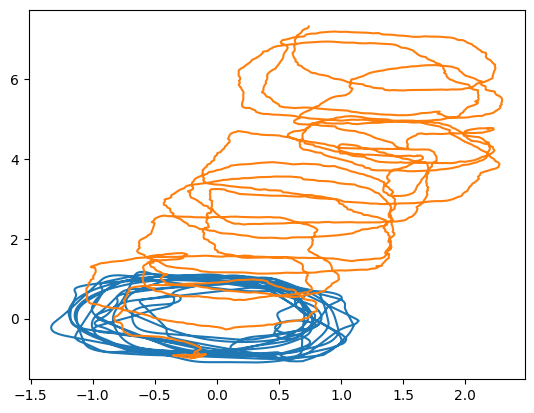

In [12]:
plt.plot(Gvx[0:2000],Gvy[0:2000])
plt.plot(Pvx[0:2000],Pvy[0:2000])

In [11]:
print(Cal_len_meters(Gvx[0:2250],Gvy[0:2250]))

100.05510247694568
